Constants

In [ ]:
TEST_DAYS             = 252       # How long the final forecast will be
WINDOW                = 252       # 1 month of history = 21; 1 year of history = 252
HORIZON               = 63        # Forcasting horizon split size

size_layer            = 256       # hidden_size
num_layers            = 3         # number of layers
dropout_rate          = 0.1       # 0.1 to 0.3
epoch                 = 400       # training iterations
learning_rate         = 3e-3      # 3e-3 to 1e-4
weight_decay          = 1e-5      # 1e-2 to 1e-5 
min_lr                = 1e-8      # lr will reduce to this value slowly
batch_size            = 128       # based on Vram
max_norm              = 5         # 1 (potentially slow training), 5 or 10 (potentially instable)
teacher_forcing_ratio = 0.7 g      # 0.1 (harder to train) to 1 (exposer bias)

Data Loading

In [2]:
import torch
import numpy as np
from sklearn.preprocessing import StandardScaler
from data_loader import create_df, make_windows

features = ["Open", "High", "Low", "Close"]
df = create_df("MSFT")

# Compute log returns
data_log = np.log(df[features] / df[features].shift(1)).fillna(0).values
data_len = len(data_log)

# index where test period starts (raw data index)
test_start = data_len - (TEST_DAYS + WINDOW)

train_raw = data_log[:test_start]
test_raw  = data_log[test_start:]

# Scale log returns
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_raw)
test_scaled = scaler.transform(test_raw)

# Make windows
X_train, Y_train = make_windows(train_scaled, WINDOW, HORIZON)
X_test,  Y_test  = make_windows(test_scaled,  WINDOW, HORIZON)

# Convert to tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
Y_train_t = torch.tensor(Y_train, dtype=torch.float32)

X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
Y_test_t  = torch.tensor(Y_test,  dtype=torch.float32)

# Sanity check
print(len(X_train_t))
print(len(X_train_t[0]))
print(len(X_test_t))
print(len(X_test_t[0]))
print()
print(len(Y_train_t))
print(len(Y_train_t[0]))
print(len(Y_test_t))
print(len(Y_test_t[0]))



1697
252
190
252

1697
63
190
63


Model Training

In [3]:
import LSTM_model as M
from training_helpers import train_model

input_size = X_train_t.shape[2]
output_size = X_train_t.shape[2]

model = M.Seq2SeqLSTM(
    input_size=input_size,
    hidden_size=size_layer,
    num_layers=num_layers,
    horizon=HORIZON,
    output_size=output_size,
    dropout=dropout_rate,
)

# Train
train_model(
    model,
    X_train_t,
    Y_train_t,
    epochs=epoch,
    lr=learning_rate,
    weight_decay=weight_decay,
    min_lr=min_lr,
    batch_size=batch_size,
    max_norm=max_norm,
    init_ratio=teacher_forcing_ratio
)

Epoch 1/400 | Total Loss: 14.128579 | Avg Loss: 1.009184 | LR: 3.00e-03
Epoch 2/400 | Total Loss: 13.019975 | Avg Loss: 0.929998 | LR: 3.00e-03
Epoch 3/400 | Total Loss: 12.697655 | Avg Loss: 0.906975 | LR: 3.00e-03
Epoch 4/400 | Total Loss: 12.664756 | Avg Loss: 0.904625 | LR: 3.00e-03
Epoch 5/400 | Total Loss: 12.399259 | Avg Loss: 0.885661 | LR: 3.00e-03
Epoch 6/400 | Total Loss: 12.183165 | Avg Loss: 0.870226 | LR: 3.00e-03
Epoch 7/400 | Total Loss: 12.190616 | Avg Loss: 0.870758 | LR: 3.00e-03
Epoch 8/400 | Total Loss: 12.012420 | Avg Loss: 0.858030 | LR: 3.00e-03
Epoch 9/400 | Total Loss: 11.959104 | Avg Loss: 0.854222 | LR: 3.00e-03
Epoch 10/400 | Total Loss: 11.875111 | Avg Loss: 0.848222 | LR: 3.00e-03
Epoch 11/400 | Total Loss: 12.055419 | Avg Loss: 0.861101 | LR: 3.00e-03
Epoch 12/400 | Total Loss: 12.266622 | Avg Loss: 0.876187 | LR: 3.00e-03
Epoch 13/400 | Total Loss: 11.980192 | Avg Loss: 0.855728 | LR: 3.00e-03
Epoch 14/400 | Total Loss: 11.514668 | Avg Loss: 0.822476 | 

Model Testing

X_test shape: torch.Size([190, 252, 4])
X_test ndim: 3
RMSE (Close): 78.0895
MAE (Close): 62.9982
Directional Accuracy: 0.538


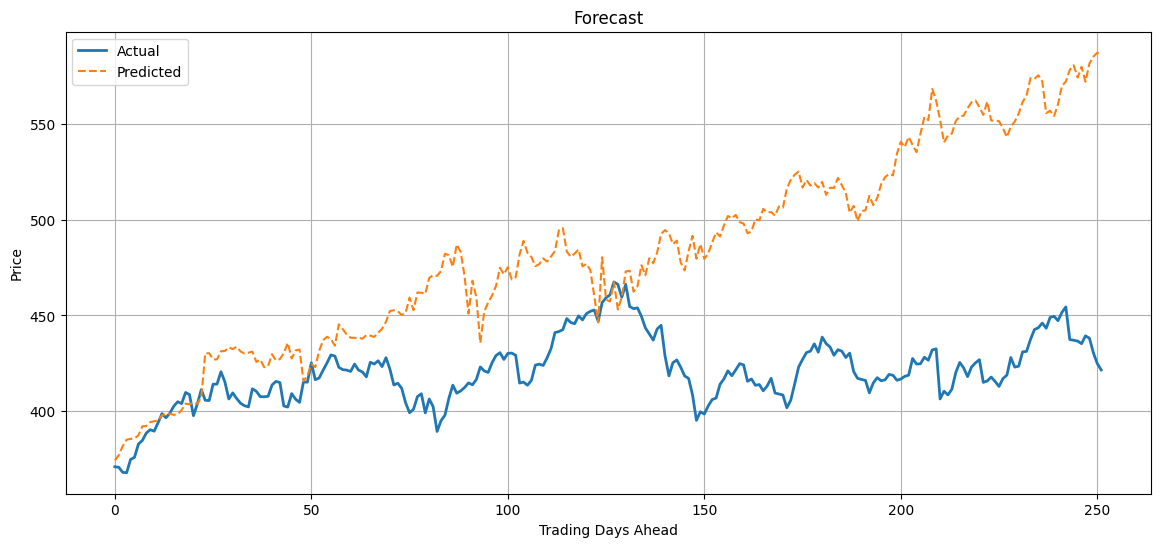

In [4]:
from testing_helpers import test_long_horizon, stats, plot

prices_test = df[features].values[test_start:]

preds = test_long_horizon(
    model, X_test_t, scaler, TEST_DAYS, HORIZON, original_prices=prices_test[:WINDOW], mode="log_return" 
)

true = df[features].values[-TEST_DAYS:]

stats(true, preds)
plot(true, preds)